<a href="https://colab.research.google.com/github/Alimv81/digital-knee-xray-image-classifier/blob/main/digital_knee_xray_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digital Knee Xray Image Processing

## dowloading and importing needed libraries

In [ ]:
!kaggle datasets download -d tommyngx/digital-knee-xray

Dataset URL: https://www.kaggle.com/datasets/tommyngx/digital-knee-xray
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 116M/117M [00:02<00:00, 65.5MB/s]
100% 117M/117M [00:02<00:00, 47.4MB/s]


In [ ]:
!unzip digital-knee-xray.zip

In [ ]:
!pip install tensorflow==2.15

In [ ]:
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
from os import listdir
import matplotlib.pyplot as plt
from os.path import join, exists

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, callbacks, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from google.colab.patches import cv2_imshow

In [ ]:
tf.__version__

'2.15.0'

## setting the tensorflow environment

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## loading the dataset into code

In [ ]:
base_path1 = '/content/MedicalExpert-I'
base_path2 = '/content/MedicalExpert-II'

### saving the images that only appear in one dataset

In [ ]:
different_opinions = []

In [ ]:
def all_datasets_in_other_dataset(path1, path2):
  flag = True

  folders1 = listdir(path1)
  folders2 = listdir(path2)

  print(folders1, folders2)

  for folder in folders1:
    for file in listdir(join(path1, folder)):
      if not exists(join(path2, folder, file)):
        flag = False
        file_path = join(path1, folder, file)
        different_opinions.append(file_path)
        print(f"'{file_path}' does not exist in the other dataset")
  return flag

In [ ]:
def same_datasets(path1, path2):
  all_of_first_datasets_images_in_second = all_datasets_in_other_dataset(path1, path2)
  all_of_second_datasets_images_in_first = all_datasets_in_other_dataset(path2, path1)

  return all_of_first_datasets_images_in_second and all_of_second_datasets_images_in_first

In [ ]:
print("\n", "two datasets are the smae" if same_datasets(base_path1, base_path2) else "the two datasets are not the same", sep='')

['1Doubtful', '0Normal', '3Moderate', '4Severe', '2Mild'] ['1Doubtful', '0Normal', '3Moderate', '4Severe', '2Mild']
'/content/MedicalExpert-I/0Normal/NormalG0 (468).png' does not exist in the other dataset
'/content/MedicalExpert-I/0Normal/NormalG0 (442).png' does not exist in the other dataset
'/content/MedicalExpert-I/0Normal/NormalG0 (390).png' does not exist in the other dataset
'/content/MedicalExpert-I/0Normal/NormalG0 (496).png' does not exist in the other dataset
'/content/MedicalExpert-I/0Normal/NormalG0 (504).png' does not exist in the other dataset
'/content/MedicalExpert-I/0Normal/NormalG0 (380).png' does not exist in the other dataset
'/content/MedicalExpert-I/0Normal/NormalG0 (509).png' does not exist in the other dataset
'/content/MedicalExpert-I/0Normal/NormalG0 (379).png' does not exist in the other dataset
'/content/MedicalExpert-I/0Normal/NormalG0 (3).png' does not exist in the other dataset
'/content/MedicalExpert-I/0Normal/NormalG0 (445).png' does not exist in the 

### creating a classes list and setting indexes based on their folders number

In [ ]:
classes = ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe']
num_classes = len(classes)

### load the dataset into code without the pictures with different medical expret opinions

In [ ]:
images = []
labels = []

In [ ]:
def load_dataset(path):
  folders = listdir(path)

  for folder in folders:
    for file in listdir(join(path, folder)):
      file_path = join(path, folder, file)
      if exists(file_path) and file_path not in different_opinions:
        img = cv.imread(file_path)
        img = cv.resize(img, (150, 150))

        label = int(folder[0])
        images.append(img)
        labels.append(label)

In [ ]:
load_dataset(base_path1)
load_dataset(base_path2)

## visualized analyses

### looking at some datasets samples

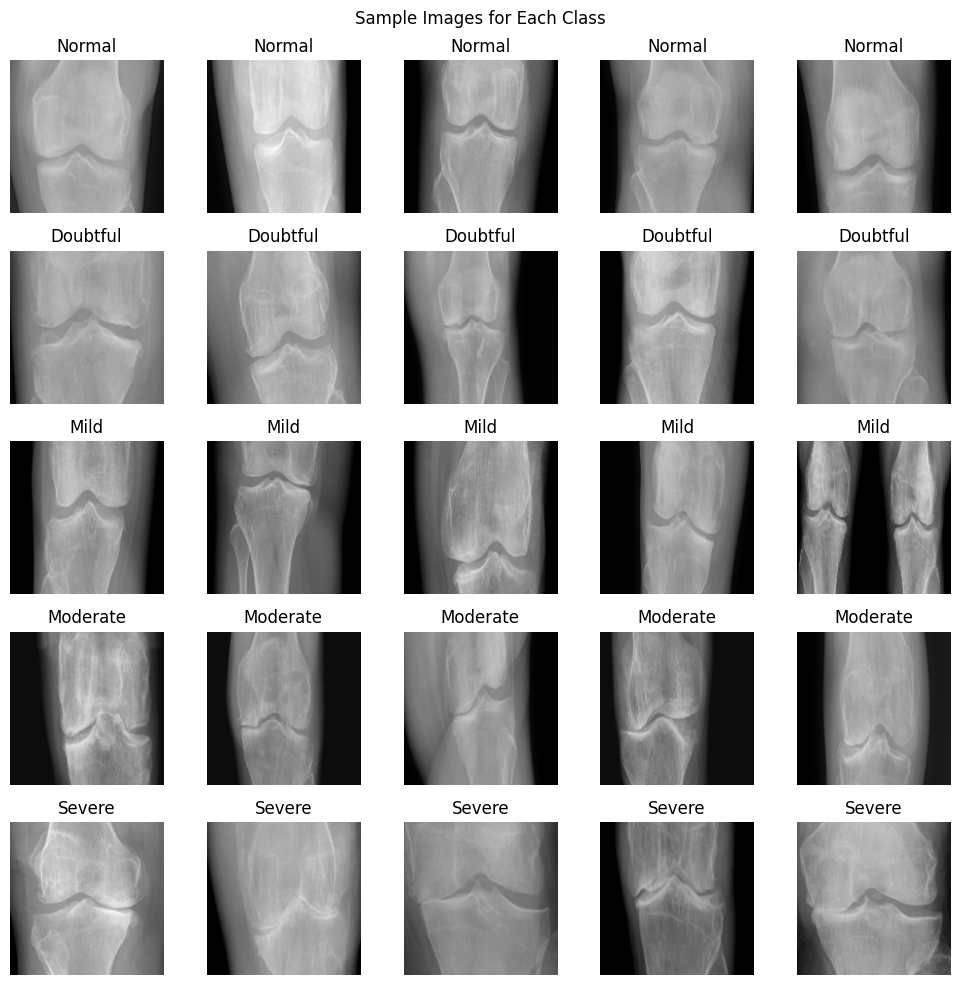

In [ ]:
def plot_sample_images(images, labels, classes, samples_per_class=5):
    fig, axes = plt.subplots(nrows=num_classes, ncols=samples_per_class, figsize=(samples_per_class*2, len(classes)*2))
    for i, cls in enumerate(classes):
        cls_images = [img for img, lbl in zip(images, labels) if lbl == i]
        for j in range(samples_per_class):
            axes[i, j].imshow(cls_images[j])
            axes[i, j].axis('off')
            axes[i, j].set_title(classes[i])
    fig.suptitle('Sample Images for Each Class')
    plt.tight_layout()
    plt.show()

plot_sample_images(images, labels, classes)

### plotting the distribution of images classes

> Add blockquote



<ipython-input-18-a74495f55a82>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='viridis', legend=False)


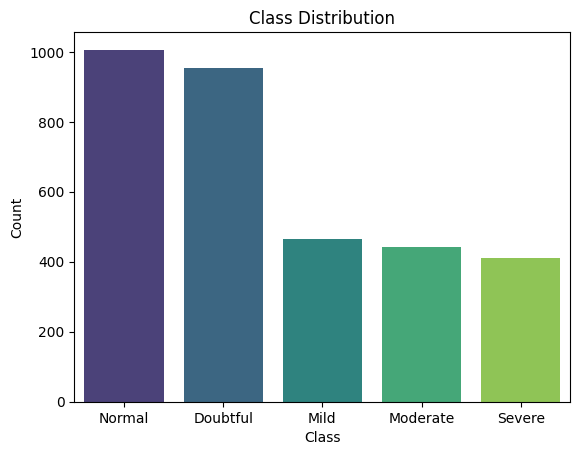

In [ ]:
def plot_class_distribution(labels):
  sns.countplot(x=labels, palette='viridis', legend=False)
  plt.xticks(np.arange(len(classes)), classes)
  plt.title('Class Distribution')
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.show()

plot_class_distribution(labels)

### looking at datasets images pca

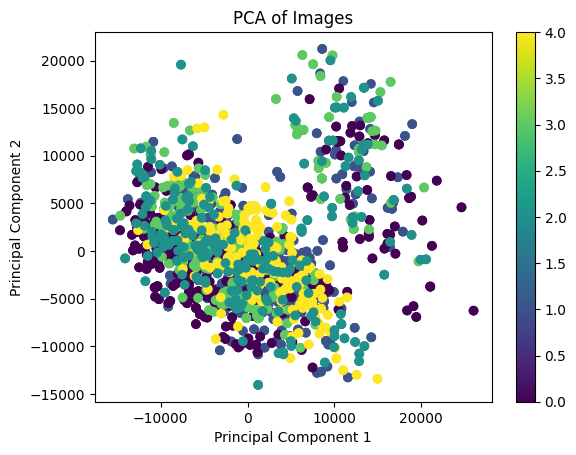

In [ ]:
def plot_pca_components(images, labels, classes):
  flattened_images = [img.flatten() for img in images]
  pca = PCA(n_components=2)
  pca_result = pca.fit_transform(flattened_images)

  plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
  plt.colorbar()
  plt.title('PCA of Images')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.show()

plot_pca_components(images, labels, classes)

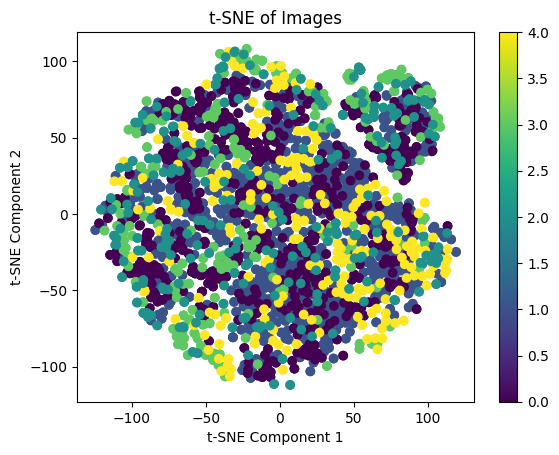

In [ ]:
def plot_tsne_components(images, labels, classes):
  flattened_images = np.array([img.flatten() for img in images])
  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(flattened_images)
  plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')

  plt.colorbar()
  plt.title('t-SNE of Images')
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.show()

plot_tsne_components(images, labels, classes)

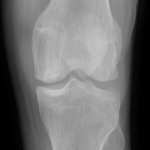

(None, 'Doubtful')

In [ ]:
idx = 220
cv2_imshow(images[idx]), classes[labels[idx]]

## preparing the dataset

### transforming the labels to categorical

In [ ]:
labels = to_categorical(labels, num_classes)

### reverting data into numpy arrays for better storage management

In [ ]:
images = np.array(images)
labels = np.array(labels)

### checking images and labels numpy arrays

In [ ]:
images.shape, images.dtype

((3278, 150, 150, 3), dtype('uint8'))

In [ ]:
labels.shape, labels.dtype

((3278, 5), dtype('float32'))

### defining preprocess function and applying to images

In [ ]:
def preprocess(img):
  return img

In [ ]:
for i in range(len(images)):
  images[i] = preprocess(images[i])

### splitting the data into train/test/validation datasets

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=.5)

## model bulding and training

### defining image datagenerator for data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

### loading vgg19 pretrained model as base model

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

outputs = base_model.output

base_model = models.Model(inputs=base_model.input, outputs=outputs)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### creating the model

In [ ]:
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

### defining callbacks for model

In [ ]:
model_callbacks = [
  callbacks.EarlyStopping(patience=10, restore_best_weights=True),
  callbacks.ModelCheckpoint("classifier.keras", save_best_only=True),
  callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
]

### designing a function that allows us to choose whether we want to use the data generator to train the model or not

In [ ]:
epochs = 35
batch_size = 32

def train_model(use_datagen):
  if not use_datagen:
    history = model.fit(
        train_images, train_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_images, val_labels),
        callbacks=model_callbacks
    )

  else:
    history = model.fit(
        datagen.flow(train_images, train_labels, batch_size=batch_size),
        epochs=epochs,
        validation_data=datagen.flow(val_images, val_labels, batch_size=batch_size),
        callbacks=model_callbacks
    )

  return history

In [ ]:
history = train_model(use_datagen=False)

Epoch 1/35
82/82 [==============================] - 22s 155ms/step - loss: 1.9483 - accuracy: 0.3501 - val_loss: 1.1872 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 2/35
82/82 [==============================] - 7s 90ms/step - loss: 1.1817 - accuracy: 0.5019 - val_loss: 0.9611 - val_accuracy: 0.6037 - lr: 0.0010
Epoch 3/35
82/82 [==============================] - 8s 97ms/step - loss: 1.0155 - accuracy: 0.5721 - val_loss: 0.8286 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 4/35
82/82 [==============================] - 8s 99ms/step - loss: 0.8806 - accuracy: 0.6438 - val_loss: 0.7487 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 5/35
82/82 [==============================] - 8s 98ms/step - loss: 0.7505 - accuracy: 0.6880 - val_loss: 0.6541 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 6/35
82/82 [==============================] - 8s 93ms/step - loss: 0.6789 - accuracy: 0.7338 - val_loss: 0.6279 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 7/35
82/82 [==============================] - 8s 101ms/step - loss: 

### visualizing the models training report

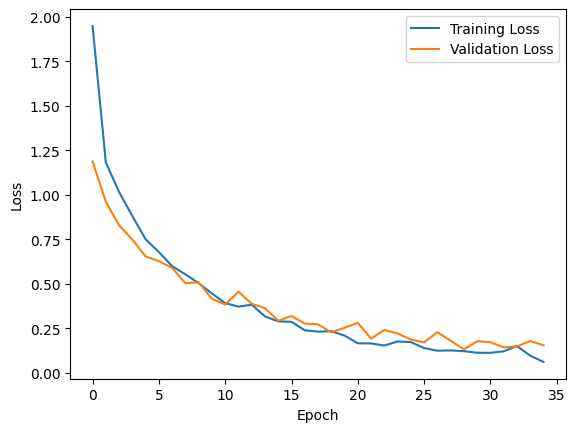

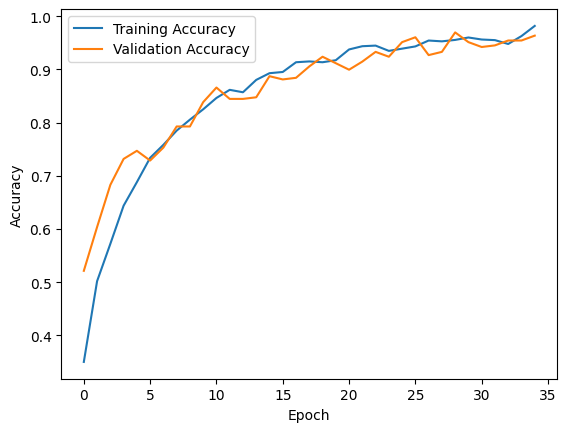

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### getting models evaluation for test datasets ouput

In [ ]:
model.evaluate(test_images, test_labels)

11/11 [==============================] - 1s 76ms/step - loss: 0.1432 - accuracy: 0.9787


[0.14320164918899536, 0.9786585569381714]

### plotting the models evaluation confusion matrix

In [ ]:
def plot_confusion_matrix(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot(cmap='viridis')

11/11 [==============================] - 1s 76ms/step


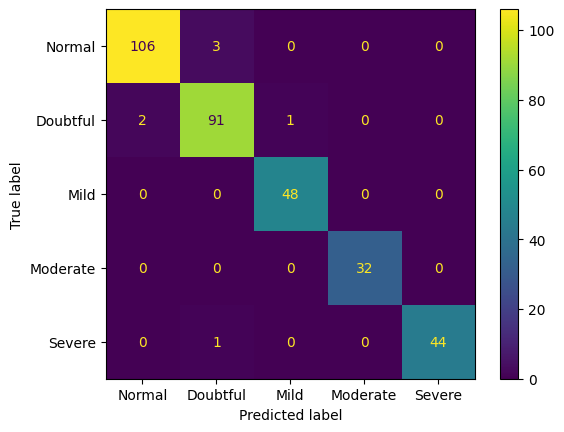

In [ ]:
plot_confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(model.predict(test_images), axis=1))

### defining a funcion that prints the models output of an image we want

In [ ]:
def test_model(idx):
  img = test_images[idx-1, :, :, :]
  label = test_labels[idx-1, :]

  pred = model.predict(np.array([img]))
  cv2_imshow(img)
  print('predicted:', classes[np.argmax(pred, axis=1)[0]], pred)
  print('actual:', classes[np.argmax(label)], label)

1/1 [==============================] - 1s 904ms/step


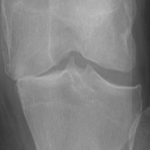

predicted: Severe [[1.2709718e-14 3.5965656e-06 5.4303619e-08 1.4812112e-04 9.9984825e-01]]
actual: Severe [0. 0. 0. 0. 1.]


In [ ]:
test_model(34)

1/1 [==============================] - 0s 39ms/step


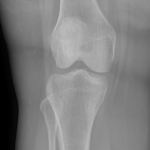

predicted: Normal [[9.9676055e-01 2.8713080e-03 3.6808511e-04 3.2417999e-10 8.2011864e-10]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 26ms/step


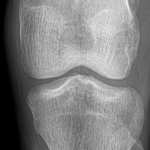

predicted: Doubtful [[8.9711182e-07 9.9999833e-01 7.2083583e-07 5.1802921e-15 2.5864955e-12]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 29ms/step


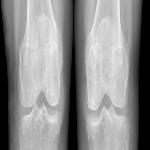

predicted: Normal [[9.9982089e-01 1.6256512e-04 1.6129641e-05 4.1884971e-07 1.2955970e-09]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 28ms/step


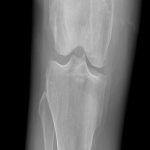

predicted: Normal [[9.99869823e-01 1.12852555e-04 1.73321023e-05 1.63001682e-10
  1.98588340e-10]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 26ms/step


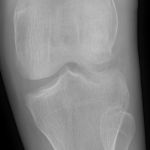

predicted: Doubtful [[2.6235638e-02 9.7330779e-01 4.5142867e-04 1.4656874e-07 4.9639752e-06]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 27ms/step


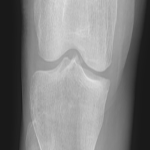

predicted: Normal [[9.9999666e-01 3.1998118e-06 1.3212542e-07 8.7496655e-13 1.3690174e-11]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 28ms/step


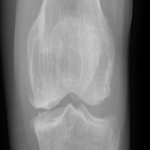

predicted: Doubtful [[2.0181842e-03 9.9776304e-01 2.1876230e-04 1.6622752e-09 3.6241993e-08]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 26ms/step


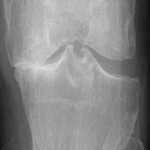

predicted: Severe [[3.4224607e-16 3.0308479e-07 3.5597560e-07 1.6475639e-03 9.9835181e-01]]
actual: Severe [0. 0. 0. 0. 1.]
********************
1/1 [==============================] - 0s 29ms/step


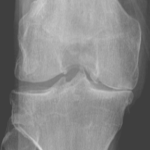

predicted: Severe [[4.8338266e-21 4.9077287e-10 9.3610935e-12 2.3197541e-07 9.9999976e-01]]
actual: Severe [0. 0. 0. 0. 1.]
********************
1/1 [==============================] - 0s 44ms/step


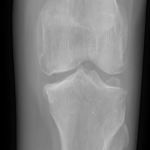

predicted: Mild [[2.9482868e-05 2.3172973e-03 9.9764949e-01 2.2816262e-06 1.4147605e-06]]
actual: Mild [0. 0. 1. 0. 0.]
********************
1/1 [==============================] - 0s 35ms/step


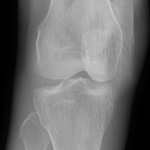

predicted: Doubtful [[4.7542643e-02 9.3992931e-01 1.1992558e-02 2.0713969e-05 5.1478040e-04]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 32ms/step


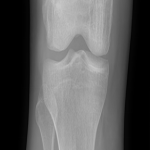

predicted: Normal [[1.0000000e+00 2.9387659e-11 9.8949147e-11 2.2437657e-14 1.7713789e-15]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 39ms/step


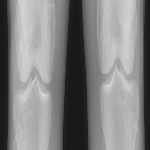

predicted: Normal [[9.9999857e-01 1.4152776e-06 5.7983052e-10 7.1804237e-14 4.6235563e-16]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 22ms/step


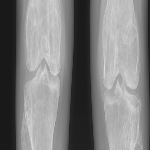

predicted: Mild [[8.5147336e-04 6.3496403e-04 9.9667203e-01 1.8156052e-03 2.5932632e-05]]
actual: Mild [0. 0. 1. 0. 0.]
********************
1/1 [==============================] - 0s 21ms/step


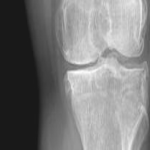

predicted: Moderate [[7.7860687e-07 3.4690893e-05 4.7649471e-03 9.9124384e-01 3.9558234e-03]]
actual: Moderate [0. 0. 0. 1. 0.]
********************
1/1 [==============================] - 0s 17ms/step


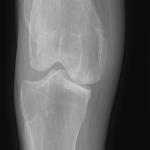

predicted: Moderate [[4.5667514e-09 3.9745591e-05 2.1454701e-03 9.7606045e-01 2.1754326e-02]]
actual: Moderate [0. 0. 0. 1. 0.]
********************
1/1 [==============================] - 0s 17ms/step


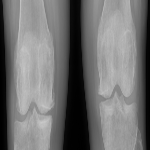

predicted: Mild [[2.1335618e-03 5.3210251e-02 9.4434118e-01 1.2322943e-04 1.9175875e-04]]
actual: Mild [0. 0. 1. 0. 0.]
********************
1/1 [==============================] - 0s 17ms/step


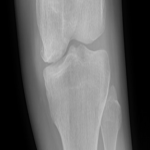

predicted: Doubtful [[3.0610105e-03 9.9555618e-01 1.3793011e-03 1.3848855e-06 2.1182598e-06]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 20ms/step


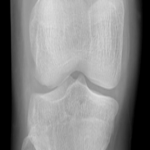

predicted: Doubtful [[9.1752229e-04 9.9905902e-01 2.1715401e-05 1.6634880e-06 6.3866779e-08]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 23ms/step


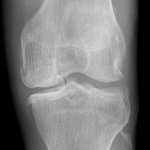

predicted: Mild [[2.3654306e-05 1.5228303e-01 8.4713048e-01 4.9683550e-08 5.6279619e-04]]
actual: Mild [0. 0. 1. 0. 0.]
********************
1/1 [==============================] - 0s 21ms/step


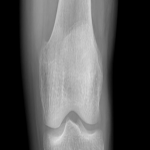

predicted: Normal [[9.9634343e-01 3.6461847e-03 5.8331943e-06 4.5589977e-06 4.8523545e-09]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 18ms/step


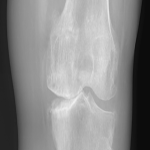

predicted: Moderate [[4.1491642e-08 2.2239037e-06 9.1839995e-04 9.9906045e-01 1.8992067e-05]]
actual: Moderate [0. 0. 0. 1. 0.]
********************
1/1 [==============================] - 0s 18ms/step


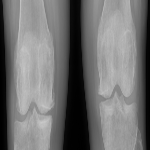

predicted: Mild [[2.1335618e-03 5.3210251e-02 9.4434118e-01 1.2322943e-04 1.9175875e-04]]
actual: Mild [0. 0. 1. 0. 0.]
********************
1/1 [==============================] - 0s 18ms/step


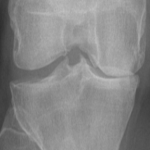

predicted: Severe [[2.6958824e-11 5.2850172e-03 1.4346778e-04 2.5465193e-05 9.9454606e-01]]
actual: Severe [0. 0. 0. 0. 1.]
********************
1/1 [==============================] - 0s 18ms/step


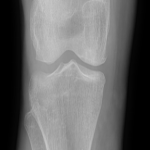

predicted: Normal [[6.7913163e-01 3.2081908e-01 4.8023263e-05 5.9319638e-07 6.0865523e-07]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 19ms/step


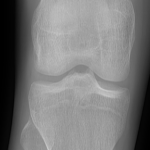

predicted: Normal [[9.9979538e-01 2.0428623e-04 4.1125531e-07 1.5621320e-12 6.1757634e-11]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 19ms/step


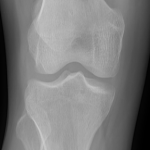

predicted: Normal [[8.4871590e-01 1.5126397e-01 1.9979623e-05 1.4867125e-08 6.9380867e-08]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 20ms/step


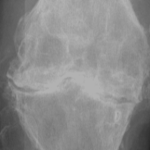

predicted: Severe [[1.5652740e-19 1.9152729e-08 6.0605923e-11 3.1582015e-09 1.0000000e+00]]
actual: Severe [0. 0. 0. 0. 1.]
********************
1/1 [==============================] - 0s 19ms/step


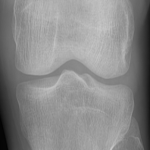

predicted: Doubtful [[4.0965825e-02 9.5883042e-01 2.0362945e-04 2.7126970e-10 9.7945430e-10]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 22ms/step


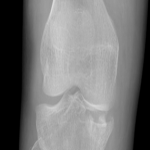

predicted: Mild [[2.5087627e-04 3.4306140e-04 9.9643904e-01 1.0805359e-03 1.8864285e-03]]
actual: Mild [0. 0. 1. 0. 0.]
********************
1/1 [==============================] - 0s 23ms/step


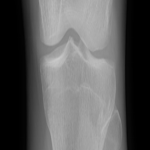

predicted: Mild [[4.6222955e-03 2.8216062e-04 9.9507457e-01 1.9870233e-05 1.0803233e-06]]
actual: Mild [0. 0. 1. 0. 0.]
********************
1/1 [==============================] - 0s 22ms/step


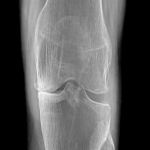

predicted: Moderate [[2.1612490e-04 1.3819875e-04 1.5726855e-03 9.9796909e-01 1.0392706e-04]]
actual: Moderate [0. 0. 0. 1. 0.]
********************
1/1 [==============================] - 0s 17ms/step


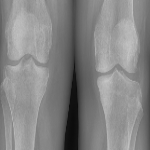

predicted: Doubtful [[6.3341542e-04 9.5580202e-01 4.0777493e-02 4.9792411e-04 2.2891769e-03]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 17ms/step


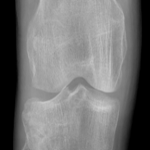

predicted: Doubtful [[4.0521633e-04 9.9951088e-01 8.3713756e-05 4.6955684e-10 1.7801874e-07]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 17ms/step


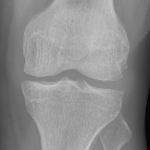

predicted: Doubtful [[9.4880746e-04 9.9905020e-01 9.9776651e-07 5.8843833e-12 2.1688962e-09]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 17ms/step


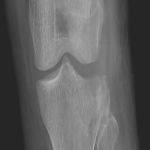

predicted: Doubtful [[2.2630145e-01 7.3132277e-01 4.2263627e-02 3.0426465e-05 8.1689730e-05]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 18ms/step


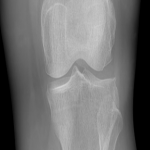

predicted: Normal [[9.9964261e-01 3.5708593e-04 1.9304505e-07 4.2248514e-11 6.5576622e-10]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 24ms/step


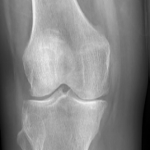

predicted: Severe [[1.3333755e-04 1.1670095e-02 3.4257018e-03 3.0488370e-03 9.8172206e-01]]
actual: Severe [0. 0. 0. 0. 1.]
********************
1/1 [==============================] - 0s 18ms/step


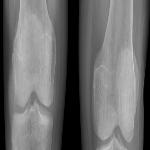

predicted: Normal [[9.7287899e-01 2.1847555e-02 5.2699749e-03 2.2666709e-06 1.1509102e-06]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 18ms/step


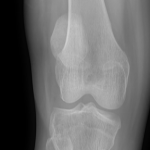

predicted: Doubtful [[2.4021300e-02 9.7523957e-01 4.3706535e-04 2.1473784e-04 8.7262313e-05]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 24ms/step


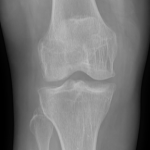

predicted: Doubtful [[9.1233905e-03 9.9029690e-01 4.1894533e-04 1.7341366e-05 1.4342953e-04]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 26ms/step


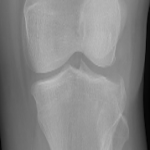

predicted: Doubtful [[9.2806546e-03 9.9064636e-01 7.3006253e-05 1.9670852e-09 4.5667434e-08]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 22ms/step


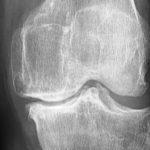

predicted: Severe [[5.4784373e-14 2.4325582e-05 3.3981822e-05 4.1939899e-07 9.9994123e-01]]
actual: Severe [0. 0. 0. 0. 1.]
********************
1/1 [==============================] - 0s 18ms/step


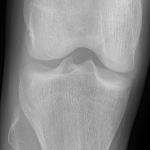

predicted: Normal [[9.9999273e-01 7.2441567e-06 3.0794503e-10 7.1375948e-12 4.0399741e-12]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 17ms/step


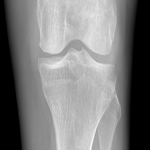

predicted: Normal [[1.0000000e+00 7.9536875e-14 7.2710241e-17 1.5332565e-17 5.4555308e-20]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 17ms/step


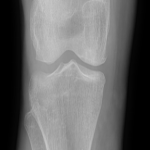

predicted: Normal [[6.7913163e-01 3.2081908e-01 4.8023263e-05 5.9319638e-07 6.0865523e-07]]
actual: Normal [1. 0. 0. 0. 0.]
********************
1/1 [==============================] - 0s 18ms/step


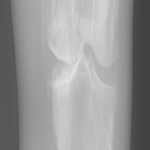

predicted: Moderate [[2.2693365e-10 3.2083709e-09 9.2809903e-04 9.9907172e-01 1.2716703e-07]]
actual: Moderate [0. 0. 0. 1. 0.]
********************
1/1 [==============================] - 0s 17ms/step


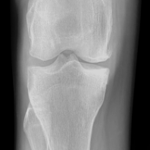

predicted: Doubtful [[5.9369677e-03 9.7778064e-01 1.6045375e-02 5.4201728e-06 2.3154517e-04]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************
1/1 [==============================] - 0s 18ms/step


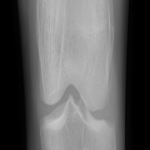

predicted: Mild [[3.7235026e-03 7.1107241e-04 9.9554729e-01 1.6296342e-05 1.9437457e-06]]
actual: Mild [0. 0. 1. 0. 0.]
********************
1/1 [==============================] - 0s 22ms/step


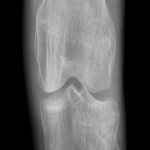

predicted: Doubtful [[3.8525159e-06 9.9999547e-01 5.3060546e-07 8.3750571e-09 7.2870883e-08]]
actual: Doubtful [0. 1. 0. 0. 0.]
********************


In [ ]:
for idx in range(50, 100):
  test_model(idx)
  print('*'*20)